In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mapply
mapply.init(n_workers=7, progressbar=True)

# Read in the data
final = pd.read_csv('../dataset/data/final_clean3.csv')

final['isKilled'] = (final['n_killed'] > 0)
final['isInjured'] = (final['n_injured'] > 0)
final['isUnharmed'] = (final['n_unharmed'] > 0)
final['isArrested'] = (final['n_arrested'] > 0)

final['congressional_district'] = final['congressional_district'].astype(str)

/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
final[['isKilled', 'n_participants']].groupby('isKilled').value_counts()

isKilled  n_participants
False     1.0               93624
          2.0               52108
          3.0               17596
          4.0                7156
          5.0                2680
          6.0                 978
          7.0                 362
          8.0                 184
          9.0                  78
          10.0                 51
          11.0                 17
          12.0                 16
          15.0                 13
          13.0                  9
          14.0                  6
          22.0                  5
          26.0                  4
          20.0                  4
          16.0                  4
          19.0                  3
          29.0                  2
          24.0                  2
          17.0                  2
          32.0                  1
          63.0                  1
          30.0                  1
          27.0                  1
          21.0                  1
True      1.0          

In [2]:
augmented = final.copy()

from sklearn.model_selection import train_test_split

train_valid, test = train_test_split(augmented, test_size=0.15)
train, valid = train_test_split(train_valid, test_size=0.15)

train: pd.DataFrame = train
valid: pd.DataFrame = valid
test: pd.DataFrame = test

idx_train = train.index
idx_valid = valid.index
idx_test = test.index


In [102]:
discretized = augmented.copy()

discretized['state_congressional_district'] = discretized['state'].astype(str) + '_' + discretized['congressional_district'].astype(str)

TO_DISCRETIZE = ['state', 'party']

cat_cols = discretized.select_dtypes(include=['object']).columns
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

def one_hot(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        vars = sorted(dataset[variable].unique())
        
        for var in vars:
            dataset[variable+'_'+str(var)] = (dataset[variable] == var).astype(int)
    return dataset

# Neural Networks
discretized = one_hot(discretized, TO_DISCRETIZE)

# Decision Trees
# discretized = discretize_data(discretized, TO_DISCRETIZE)

discretized = discretized.drop(columns=cat_cols)

discretized.shape


(235219, 131)

In [103]:
f = discretized.copy()

isKilled = f['isKilled']

del f['isKilled']
del f['isInjured']
del f['isUnharmed']
del f['isArrested']

keywords = ['n_', 'date', 'killed', 'arrested', 'injured', 'unharmed', '_males', 'n_participants', 'DEAD', 'CLEAN', 'OUTLIER', 'incident_', 'cd_', 'state_']
whitelist = ['participants_', 'n_injured', 'n_unharmed', 'n_arrested', 'state_year_p_', 'n_incidents_city_week', '_num']
blacklist = ['killed', 'adult']

# del all columns with keywords in it
deleted = []
for col in f.columns:
    if any([b in col for b in blacklist]):
        deleted.append(col)
        del f[col]
    elif any([w in col for w in keywords]) and not any([w in col for w in whitelist]):
        deleted.append(col)
        del f[col]

print(f.columns)

f = f.astype('float64')

for col in f.columns:
    if 'n_' in col:
        f[col] = f[col].astype('int64')
    if 'timestamp' in col:
        f[col] = f[col].astype('int64')
    if 'totalvotes' in col:
        f[col] = f[col].astype('int64')
    if 'party_' in col:
        f[col] = f[col].astype('int64')
    if 'num' in col:
        f[col] = f[col].astype('int64')


Index(['latitude', 'longitude', 'avg_age_participants', 'max_age_participants',
       'n_participants_child', 'n_participants_teen', 'n_injured',
       'n_arrested', 'n_unharmed', 'timestamp', 'povertyPercentage',
       'totalvotes', 'p_females', 'p_participants_child',
       'p_participants_teen', 'month_cd_ratio_participants_child',
       'month_cd_ratio_participants_teen',
       'month_state_ratio_participants_child',
       'month_state_ratio_participants_teen', 'percentage_republican',
       'percentage_democrat', 'party_DEMOCRAT', 'party_REPUBLICAN'],
      dtype='object')


In [104]:
from sklearn.preprocessing import StandardScaler as S

scaler = S()

# Scale the data
scaled = scaler.fit_transform(f)

# Convert to a dataframe
scaled = pd.DataFrame(scaled, columns=f.columns)

scaled = scaled.drop_duplicates()


# Do not scale if using a tree-based model
# scaled = f

In [105]:
UPSAMPLE   = False
DOWNSAMPLE = False
UPDOWNSAMPLE = False
SMOTE = False
SMOTEUPSAMPLE = True

SAMPLE_TRAIN = True
SAMPLE_VALID = True
SAMPLE_TEST  = True

scaled['isKilled'] = isKilled * 1

# Remove rows where n_killed == n_participants
min_injured = scaled['n_injured'].min()
min_unharmed = scaled['n_unharmed'].min()
min_arrested = scaled['n_arrested'].min()

scaled = scaled[~((scaled['n_injured'] == min_injured) & (scaled['n_unharmed'] == min_unharmed) & (scaled['n_arrested'] == min_arrested))]

train = scaled[scaled.index.isin(idx_train)]
valid = scaled[scaled.index.isin(idx_valid)]
test = scaled[scaled.index.isin(idx_test)]


def rebalance(df, size):
    if df.shape[0] < size:
        return df.sample(size, replace=True, random_state=0)
    else:
        return df.sample(size, random_state=0)

# Upsample train, valid, and test
if UPSAMPLE:
    train_vc = train['isKilled'].value_counts()
    valid_vc = valid['isKilled'].value_counts()
    test_vc = test['isKilled'].value_counts()
    max_train_vc = train_vc.max()
    max_valid_vc = valid_vc.max()
    max_test_vc = test_vc.max()
    train = train.groupby('isKilled').apply(lambda x: rebalance(x, max_train_vc)).reset_index(drop=True) if SAMPLE_TRAIN else train
    valid = valid.groupby('isKilled').apply(lambda x: rebalance(x, max_valid_vc)).reset_index(drop=True) if SAMPLE_VALID else valid
    test = test.groupby('isKilled').apply(lambda x: rebalance(x, max_test_vc)).reset_index(drop=True) if SAMPLE_TEST else test
# Downsample train, valid, and test
elif DOWNSAMPLE:
    train_vc = train['isKilled'].value_counts()
    valid_vc = valid['isKilled'].value_counts()
    test_vc = test['isKilled'].value_counts()
    min_train_vc = train_vc.min()
    min_valid_vc = valid_vc.min()
    min_test_vc = test_vc.min()
    train = train.groupby('isKilled').apply(lambda x: rebalance(x, min_train_vc)).reset_index(drop=True) if SAMPLE_TRAIN else train
    valid = valid.groupby('isKilled').apply(lambda x: rebalance(x, min_valid_vc)).reset_index(drop=True) if SAMPLE_VALID else valid
    test = test.groupby('isKilled').apply(lambda x: rebalance(x, min_test_vc)).reset_index(drop=True) if SAMPLE_TEST else test
# Downsample train, upsample valid and test
elif UPDOWNSAMPLE:
    train_vc = train['isKilled'].value_counts()
    min_train_vc = train_vc.min()
    old_train = train.copy()
    train = train.groupby('isKilled').apply(lambda x: rebalance(x, min_train_vc)).reset_index(drop=True) if SAMPLE_TRAIN else train
    removed_train = old_train[~old_train.index.isin(train.index)]
    to_add_to_valid = removed_train.sample(frac=0.5, random_state=0)
    to_add_to_test = removed_train.drop(to_add_to_valid.index)
    valid = pd.concat([valid, to_add_to_valid])
    test = pd.concat([test, to_add_to_test])
    valid_vc = valid['isKilled'].value_counts()
    test_vc = test['isKilled'].value_counts()
    max_valid_vc = valid_vc.max()
    max_test_vc = test_vc.max()
    valid = valid.groupby('isKilled').apply(lambda x: rebalance(x, max_valid_vc)).reset_index(drop=True) if SAMPLE_VALID else valid
    test = test.groupby('isKilled').apply(lambda x: rebalance(x, max_test_vc)).reset_index(drop=True) if SAMPLE_TEST else test
# SMOTE on Train, valid, and test
elif SMOTE:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=0)
    X_train, y_train = train.drop(columns=['isKilled']), train['isKilled']
    X_valid, y_valid = valid.drop(columns=['isKilled']), valid['isKilled']
    X_test, y_test = test.drop(columns=['isKilled']), test['isKilled']
    X_train, y_train = sm.fit_resample(X_train, y_train)
    X_valid, y_valid = sm.fit_resample(X_valid, y_valid)
    X_test, y_test = sm.fit_resample(X_test, y_test)
    train = pd.concat([X_train, y_train], axis=1)
    valid = pd.concat([X_valid, y_valid], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
# SMOTE on Train, upsample on valid and test
elif SMOTEUPSAMPLE:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=0)
    X_train, y_train = train.drop(columns=['isKilled']), train['isKilled']
    X_train, y_train = sm.fit_resample(X_train, y_train)
    train = pd.concat([X_train, y_train], axis=1)
    valid_vc = valid['isKilled'].value_counts()
    test_vc = test['isKilled'].value_counts()
    max_valid_vc = valid_vc.max()
    max_test_vc = test_vc.max()
    valid = valid.groupby('isKilled').apply(lambda x: rebalance(x, max_valid_vc)).reset_index(drop=True) if SAMPLE_VALID else valid
    test = test.groupby('isKilled').apply(lambda x: rebalance(x, max_test_vc)).reset_index(drop=True) if SAMPLE_TEST else test    



X_train = train.drop(columns=['isKilled'])
y_train = train['isKilled']

X_valid = valid.drop(columns=['isKilled'])
y_valid = valid['isKilled']

X_test = test.drop(columns=['isKilled'])
y_test = test['isKilled']

print(X_train.shape, y_train.shape, '\n', y_train.value_counts())
print(X_valid.shape, y_valid.shape, '\n', y_valid.value_counts())
print(X_test.shape, y_test.shape, '\n', y_test.value_counts())

(252854, 23) (252854,) 
 isKilled
1    126427
0    126427
Name: count, dtype: int64
(44550, 23) (44550,) 
 isKilled
0    22275
1    22275
Name: count, dtype: int64
(52338, 23) (52338,) 
 isKilled
0    26169
1    26169
Name: count, dtype: int64


# Decision tree classifier

## GS

In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import ParameterGrid

# calculate class_weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

print(class_weights)

# Create the parameters list you wish to tune
parameters = {
    'max_depth': [x for x in np.logspace(1, 5, 5, base=2).astype(int)] + [None],
    'min_samples_split': [x for x in np.logspace(1, 4, 4, base=2).astype(int)],
    'min_samples_leaf': [x for x in np.logspace(0, 3, 4, base=2).astype(int)],
}

print('Grid searching with {} parameter sets'.format(len(ParameterGrid(parameters))))

import time
def fit(params):
    start = time.time()
    clf = DecisionTreeClassifier(random_state=0, class_weight=class_weights)
    clf.set_params(**params)
    clf.fit(X_train, y_train)
    y_pred_valid = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred_valid)
    end = time.time()
    print('Score: {:.4f} | Time: {:.2f}s | Params: {}'.format(score, end-start, params))
    return (score, clf)

from joblib import Parallel, delayed
results = Parallel(n_jobs=-1)(delayed(fit)(params) for params in ParameterGrid(parameters))
results_df = pd.DataFrame(results, columns=['score', 'clf'])
results_df = results_df.sort_values(by='score', ascending=False)
best_clf = results_df.iloc[0]['clf']
best_score = results_df.iloc[0]['score']
best_params = best_clf.get_params()

# Make predictions using the unoptimized and model
clf = DecisionTreeClassifier(random_state=0, class_weight=class_weights)
predictions = (clf.fit(X_train, y_train)).predict(X_valid)

best_predictions = best_clf.predict(X_valid)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("F1 score on validation data: {:.4f}".format(f1_score(y_valid, predictions)))
print("F1-score on validation data: \n{}".format(classification_report(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final F1 score on the validation data: {:.4f}".format(f1_score(y_valid, best_predictions)))
print("Final F1-score on the validation data: \n{}".format(classification_report(y_valid, best_predictions)))


{0: 1.0, 1: 1.0}
Grid searching with 96 parameter sets
Score: 0.6636 | Time: 1.73s | Params: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 16}
Score: 0.6636 | Time: 1.78s | Params: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
Score: 0.6636 | Time: 2.06s | Params: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Score: 0.6636 | Time: 1.93s | Params: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4}
Score: 0.6636 | Time: 2.05s | Params: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 8}
Score: 0.6636 | Time: 1.86s | Params: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 16}
Score: 0.6636 | Time: 1.89s | Params: {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2}
Score: 0.6636 | Time: 1.97s | Params: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 8}
Score: 0.6636 | Time: 1.80s | Params: {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 16}
Score: 0.6636 | Time: 2.

In [96]:
# Optimized Model
print(best_clf.get_params())

{'ccp_alpha': 0.0, 'class_weight': {0: 1.0, 1: 1.0}, 'criterion': 'gini', 'max_depth': 16, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


Accuracy: 0.7602
Precision: 0.9061
Recall: 0.5806
F1: 0.7077
ROC AUC: 0.7602


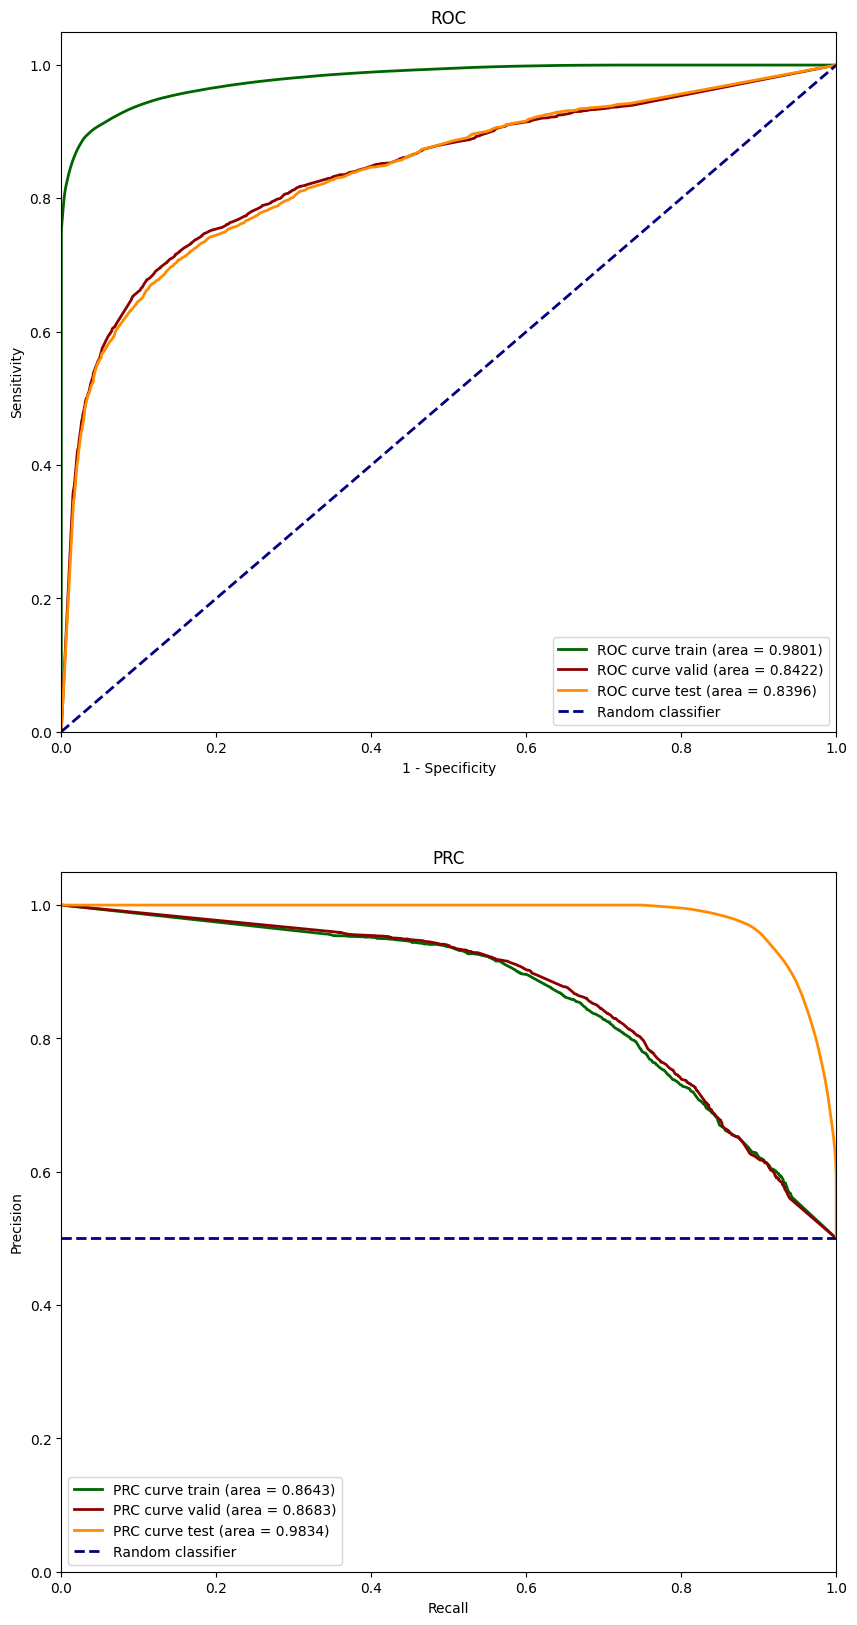

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
y_pred_test = best_clf.predict(X_test)

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_test)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_test)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_test)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_test)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_test)))

# roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_train = best_clf.predict_proba(X_train)[:, 1]
y_pred_valid = best_clf.predict_proba(X_valid)[:, 1]
y_pred_test = best_clf.predict_proba(X_test)[:, 1]



fprr_dt, tprr_dt,  _ = roc_curve(y_train, y_pred_train)
fprv_dt, tprv_dt,  _ = roc_curve(y_valid, y_pred_valid)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_test)

roc_aucr_dt = auc(fprr_dt, tprr_dt)
roc_aucv_dt = auc(fprv_dt, tprv_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)


precr_dt, recr_dt, _ = precision_recall_curve(y_test, y_pred_test)
precv_dt, recv_dt, _ = precision_recall_curve(y_valid, y_pred_valid)
prect_dt, rect_dt, _ = precision_recall_curve(y_train, y_pred_train)

prc_aucr_dt = auc(recr_dt, precr_dt)
prc_aucv_dt = auc(recv_dt, precv_dt)
prc_auc_dt = auc(rect_dt, prect_dt)


fig, axs = plt.subplots(2, 1, figsize=(10, 20))
ax = axs[0]
ax.plot(fprr_dt, tprr_dt, color='darkgreen', lw=2, label='ROC curve train (area = {:.4f})'.format(roc_aucr_dt))
ax.plot(fprv_dt, tprv_dt, color='darkred', lw=2, label='ROC curve valid (area = {:.4f})'.format(roc_aucv_dt))
ax.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve test (area = {:.4f})'.format(roc_auc_dt))
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
ax.set_title('ROC')
ax.legend(loc="lower right")

ax = axs[1]
ax.plot(recr_dt, precr_dt, color='darkgreen', lw=2, label='PRC curve train (area = {:.4f})'.format(prc_aucr_dt))
ax.plot(recv_dt, precv_dt, color='darkred', lw=2, label='PRC curve valid (area = {:.4f})'.format(prc_aucv_dt))
ax.plot(rect_dt, prect_dt, color='darkorange', lw=2, label='PRC curve test (area = {:.4f})'.format(prc_auc_dt))
ax.plot([0, 1], [.5, .5], color='navy', lw=2, linestyle='--', label='Random classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('PRC')
ax.legend(loc="lower left")

plt.show()
plt.show()

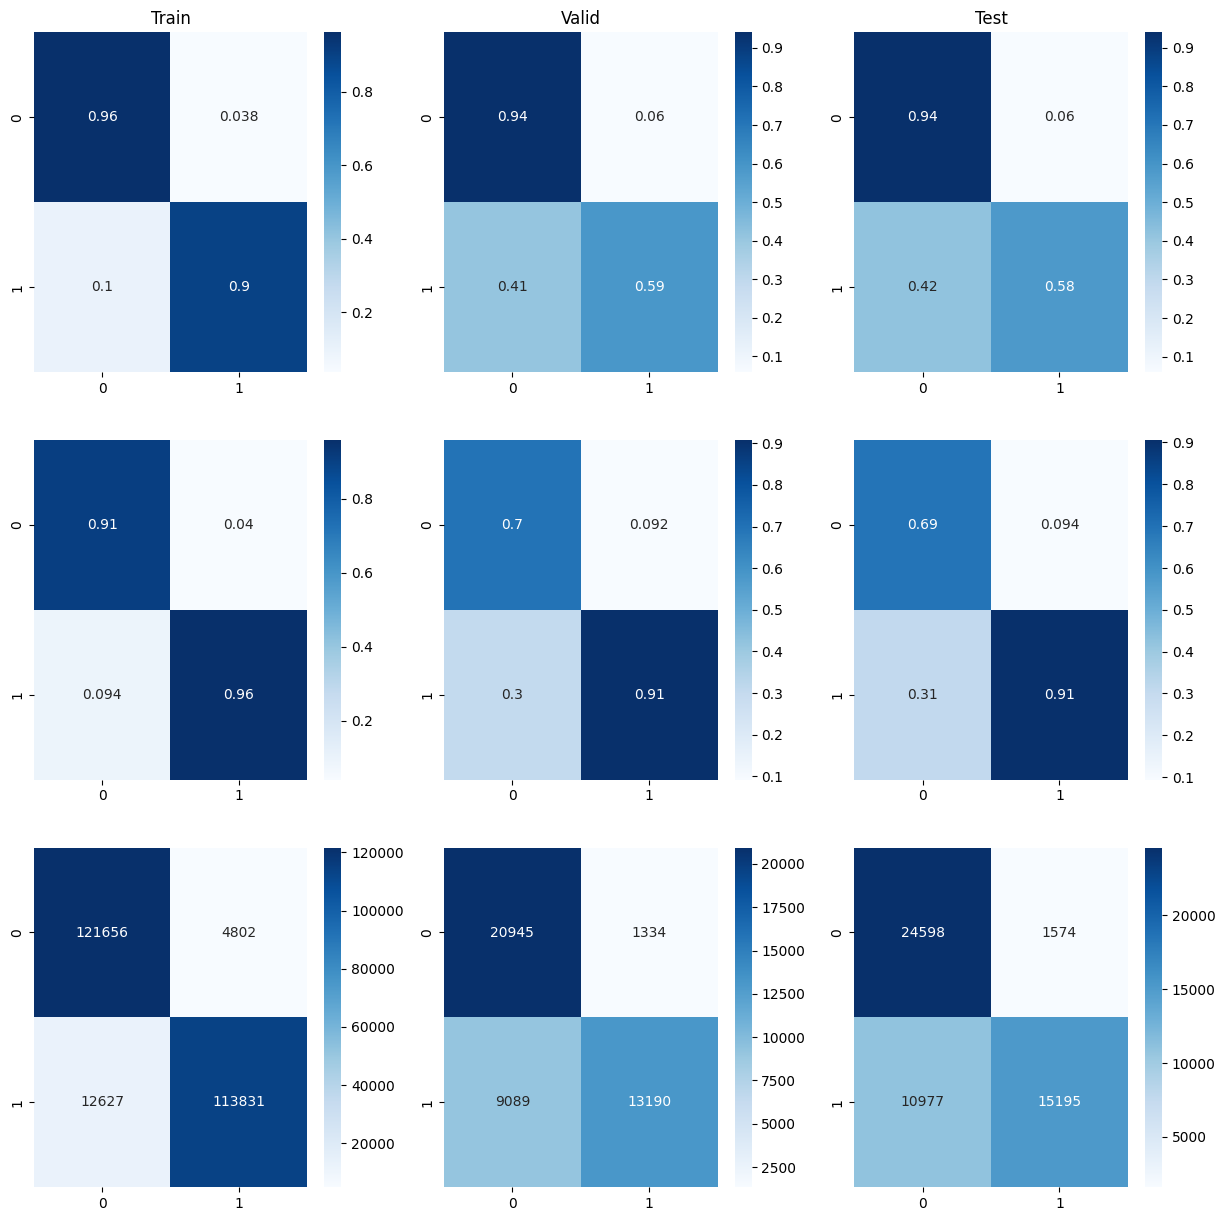

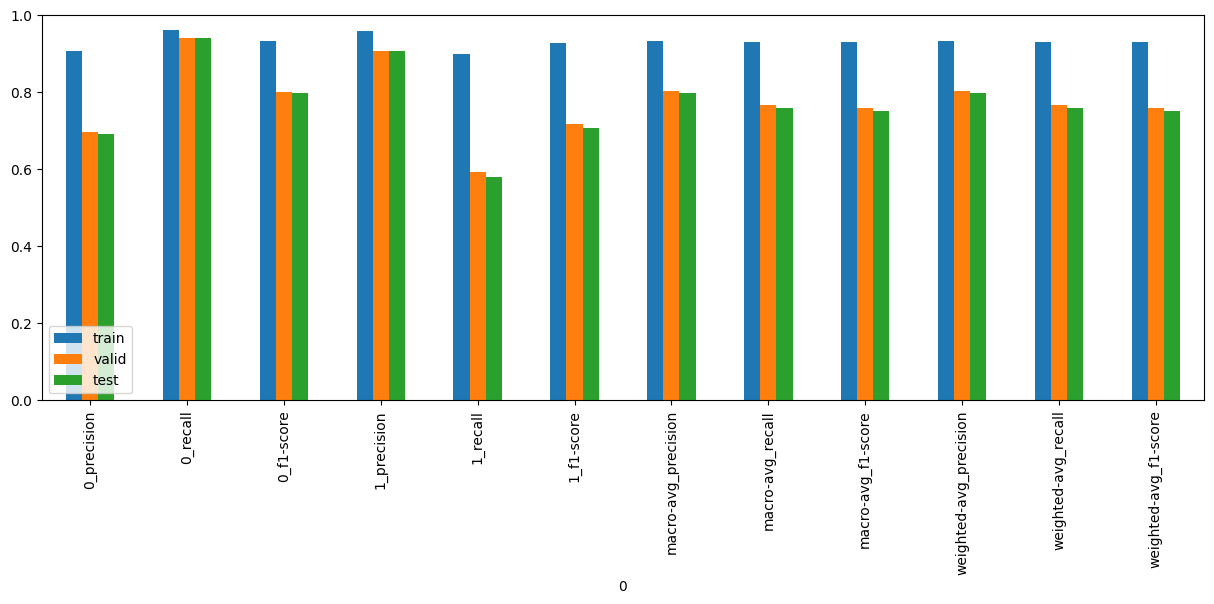

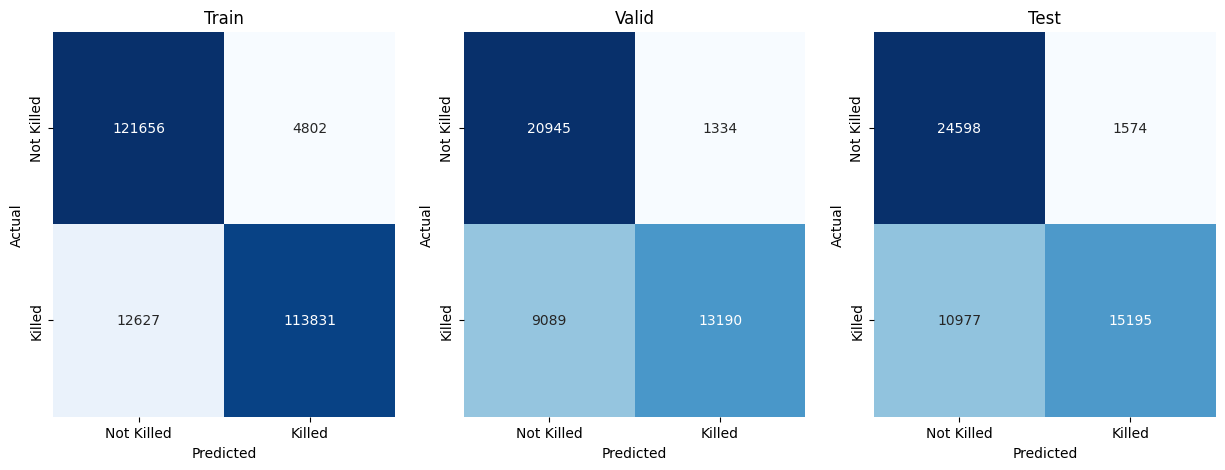

In [98]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def writable(class_report, base_key = '', separator = '_'):
    for key, value in class_report.items():
        if isinstance(value, dict):
            yield from writable(value, key)
        else:
            yield str(base_key + separator + key).replace(' ', '-'), value

y_pred_train = best_clf.predict(X_train)
y_pred_valid = best_clf.predict(X_valid)
y_pred_test = best_clf.predict(X_test)

# Confusion matrices
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs[0][0].set_title('Train')
axs[0][1].set_title('Valid')
axs[0][2].set_title('Test')
sns.heatmap(confusion_matrix(y_train, y_pred_train, normalize='true'), annot=True, ax=axs[0][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid, normalize='true'), annot=True, ax=axs[0][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize='true'), annot=True, ax=axs[0][2], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_train, y_pred_train, normalize='pred'), annot=True, ax=axs[1][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid, normalize='pred'), annot=True, ax=axs[1][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize='pred'), annot=True, ax=axs[1][2], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d' , ax=axs[2][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt='d', ax=axs[2][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', ax=axs[2][2], cmap = 'Blues')
plt.show()

from sklearn.metrics import classification_report
# Scores
fig, ax = plt.subplots(figsize=(15, 5))
tr_cr = pd.DataFrame(writable(classification_report(y_train, y_pred_train, labels=[0, 1], output_dict=True), 'train'), columns=['0', 'train'])
tr_cr.set_index('0', inplace=True)
va_cr = pd.DataFrame(writable(classification_report(y_valid, y_pred_valid, labels=[0, 1], output_dict=True), 'valid'), columns=['0', 'valid'])
va_cr.set_index('0', inplace=True)
te_cr = pd.DataFrame(writable(classification_report(y_test, y_pred_test, labels=[0, 1], output_dict=True), 'test'), columns=['0', 'test'])
te_cr.set_index('0', inplace=True)

trvate = tr_cr.merge(va_cr, left_index=True, right_index=True)
trvate = trvate.merge(te_cr, left_index=True, right_index=True)

# remove all rows where index contains 'support'
trvate = trvate[~trvate.index.str.contains('support')]

trvate.plot.bar(ax=ax)
plt.ylim(0, 1)
plt.legend(loc='lower left')
plt.show()

# Plot for the paper
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('Train')
axs[1].set_title('Valid')
axs[2].set_title('Test')
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d' , ax=axs[0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt='d', ax=axs[1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', ax=axs[2], cmap = 'Blues')
for i in range(0, 3):
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')
    axs[i].set_xticklabels(['Not Killed', 'Killed'])
    axs[i].set_yticklabels(['Not Killed', 'Killed'])
    axs[i].collections[0].colorbar.remove()
plt.show()


In [99]:
# f1 scores of train, valid, and test
print('Train F1: {:.4f}'.format(f1_score(y_train, y_pred_train)))
print('Valid F1: {:.4f}'.format(f1_score(y_valid, y_pred_valid)))
print('Test F1: {:.4f}'.format(f1_score(y_test, y_pred_test)))

Train F1: 0.9289
Valid F1: 0.7168
Test F1: 0.7077


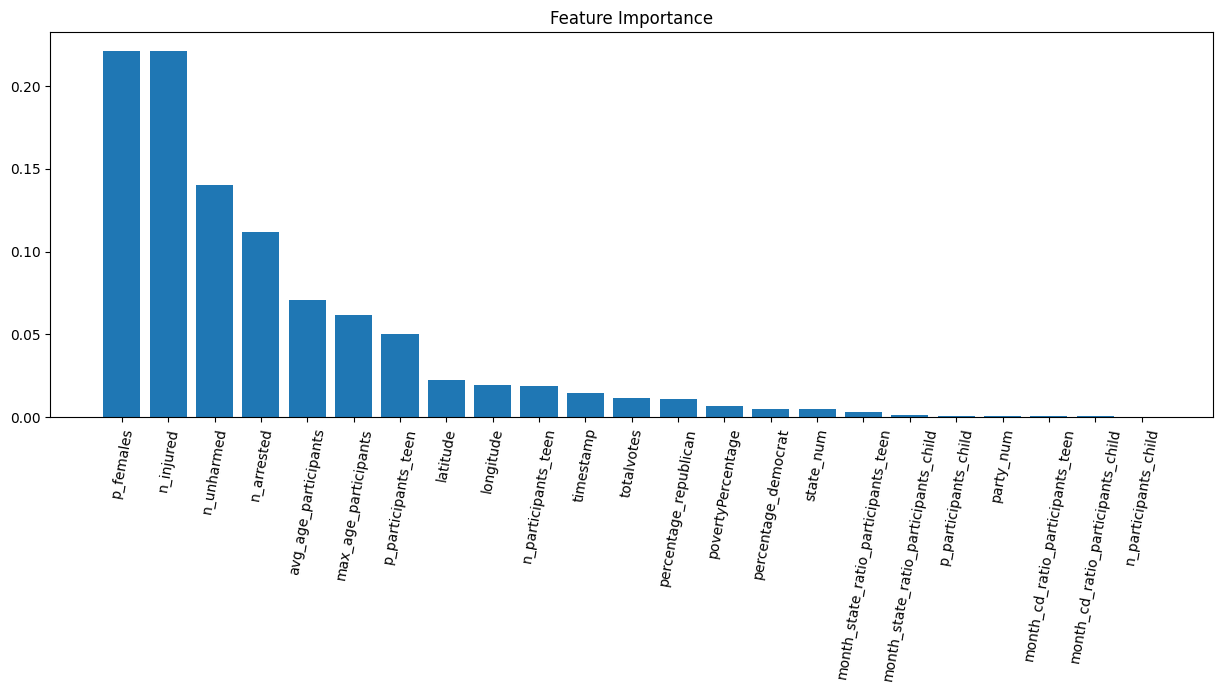

In [100]:
importances = best_clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(15, 5))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=80)

plt.show()

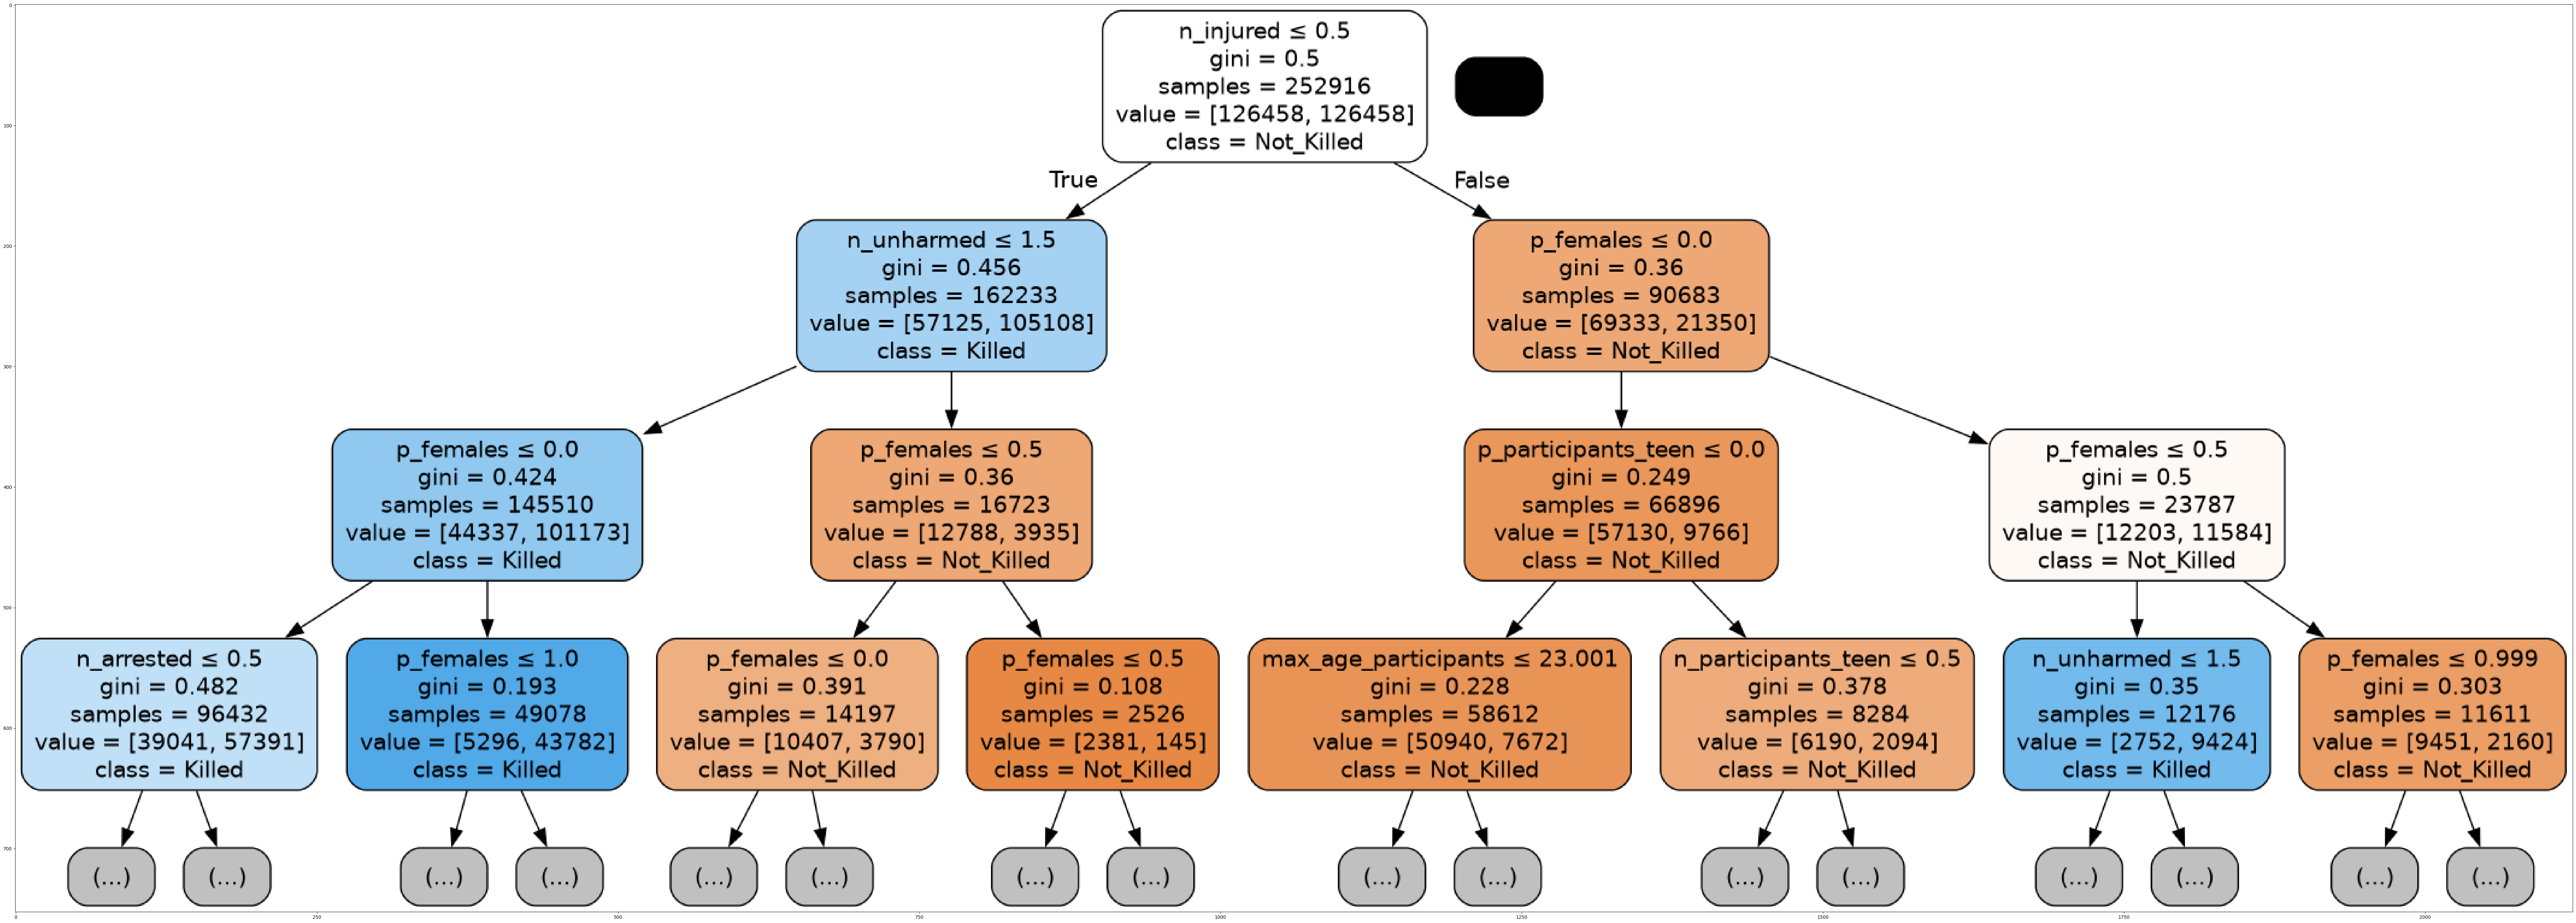

In [101]:
from sklearn.tree import export_graphviz

import pydotplus

# from IPython.display import Image
dot_data = export_graphviz(best_clf, out_file=None, feature_names=X_train.columns, class_names=['Not_Killed', 'Killed'], filled=True, rounded=True, special_characters=True, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('graph.png')

image = plt.imread('graph.png')
plt.figure(figsize=(100, 100))
plt.imshow(image)
plt.show()

# Neural network

[1. 1.]
[Linear(in_features=23, out_features=32, bias=True),
 Sigmoid(),
 Dropout(p=0.1, inplace=False),
 Linear(in_features=32, out_features=16, bias=True),
 Sigmoid(),
 Dropout(p=0.1, inplace=False),
 Linear(in_features=16, out_features=8, bias=True),
 Sigmoid(),
 Dropout(p=0.1, inplace=False),
 Linear(in_features=8, out_features=4, bias=True),
 Sigmoid(),
 Dropout(p=0.1, inplace=False),
 Linear(in_features=4, out_features=2, bias=True),
 Softmax(dim=1)]
Epoch 1/50000, Loss: 0.7000, F1: 0.1972, valid F1: 0.2012
Epoch 101/50000, Loss: 0.6944, F1: 0.5593, valid F1: 0.5575
Epoch 201/50000, Loss: 0.6712, F1: 0.6051, valid F1: 0.6096
Epoch 301/50000, Loss: 0.6359, F1: 0.6539, valid F1: 0.6628
Epoch 401/50000, Loss: 0.6160, F1: 0.6724, valid F1: 0.6815
Epoch 501/50000, Loss: 0.6001, F1: 0.6788, valid F1: 0.6832
Epoch 601/50000, Loss: 0.5858, F1: 0.6854, valid F1: 0.6847
Epoch 701/50000, Loss: 0.5755, F1: 0.6913, valid F1: 0.6848
Epoch 801/50000, Loss: 0.5650, F1: 0.6996, valid F1: 0.6912
E

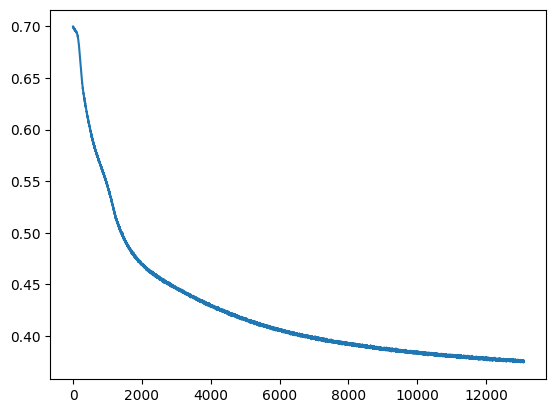

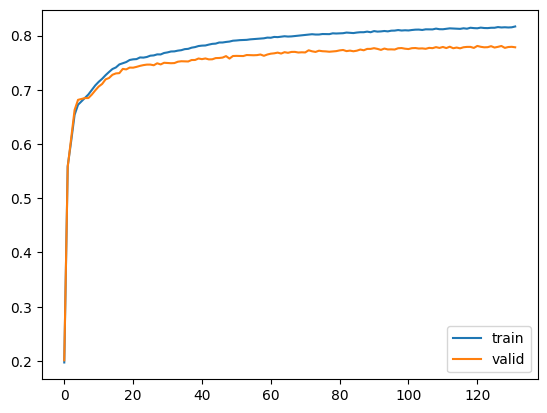

In [106]:
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
from sklearn.metrics import f1_score

writer = SummaryWriter()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(DEVICE)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(DEVICE)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).to(DEVICE)

input_size = X_train_tensor.shape[1]
N_HIDDEN = 5
BASE = 2
hidden_size = BASE ** N_HIDDEN
output_size = 1


# calculate class_weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(class_weights)

weights = np.where(y_train == 1, class_weights[1], class_weights[0])
weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)

loss_function = nn.BCELoss(weight=weights)

learning_rate = 1e-3

model_params = [
    nn.Linear(input_size, hidden_size),
]

last_hidden_size = hidden_size
for i in range(1, N_HIDDEN):
    this_hidden_size = hidden_size // (BASE ** i)
    model_params += [
        nn.Sigmoid(),
        nn.Dropout(0.1),
        nn.Linear(last_hidden_size, this_hidden_size),
    ]
    last_hidden_size = this_hidden_size
model_params += [
    nn.Softmax(dim=output_size),
]

from pprint import pprint
pprint(model_params)

model = nn.Sequential(*model_params).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

EPOCHS = 50000
losses = []
epochs = []
accs = []
accs_valid = []

TOLERANCE = 1e-4
PATIENCE = 10 # Keeping into account that it is evaluated every 100 epochs

max_valid = -1e10
patience = 0

model.train()
for epoch in range(EPOCHS):
    try:
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)[:, 1]
        loss = loss_function(y_pred, y_train_tensor)
        writer.add_scalar('Loss/train', loss.item(), epoch)
        losses.append(loss.item())
        if epoch % 100 == 0:
            acc = f1_score(y_train_tensor.detach().cpu().numpy(), np.where(y_pred.detach().cpu() > 0.5, 1, 0))
            accs.append(acc)
            y_pred_valid = model(X_valid_tensor)
            y_pred_valid = y_pred_valid.squeeze(1)[:, 1].unsqueeze(1)
            acc_valid = f1_score(y_valid_tensor.detach().cpu().numpy(), np.where(y_pred_valid.detach().cpu() > 0.5, 1, 0))
            accs_valid.append(acc_valid)
            print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, F1: {acc:.4f}, valid F1: {acc_valid:.4f}')
            writer.add_scalar('F1/train', acc, epoch)
            writer.add_scalar('F1/valid', acc_valid, epoch)

            if acc_valid > max_valid + TOLERANCE:
                max_valid = acc_valid
                patience = 0
            else:
                patience += 1
                if patience > PATIENCE:
                    break

        loss.backward()
        optimizer.step()
    except KeyboardInterrupt:
        break

from sklearn.metrics import confusion_matrix

# Convert the valid data to PyTorch tensors and get the predicted class
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(DEVICE)
y_pred_tensor = model(X_valid_tensor)[:, 1].unsqueeze(1).detach().cpu()

y_pred = np.where(y_pred_tensor > 0.5, 1, 0)

# # Print the confusion matrix
print(confusion_matrix(y_valid, y_pred))

# # Print the accuracy
from sklearn.metrics import f1_score
print(f1_score(y_valid, y_pred))

# plot the loss over the entire training procedure
plt.plot(losses)
plt.show()

# plot the F1 scores in training and validation
plt.plot(accs, label='train')
plt.plot(accs_valid, label='valid')
plt.legend()
plt.show()


## Results

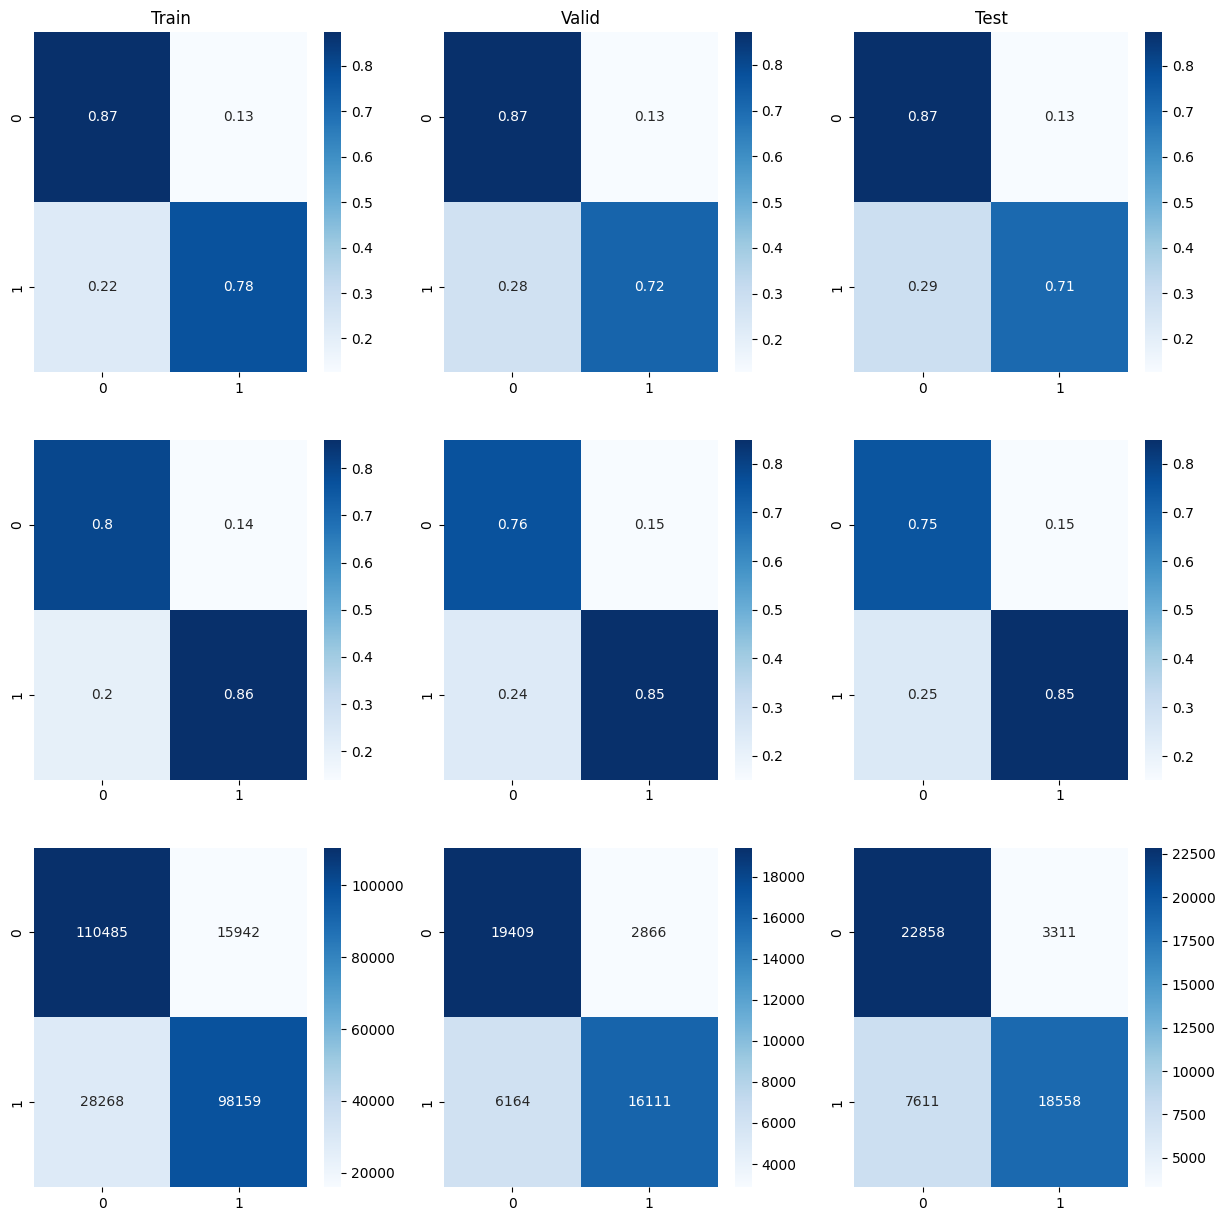

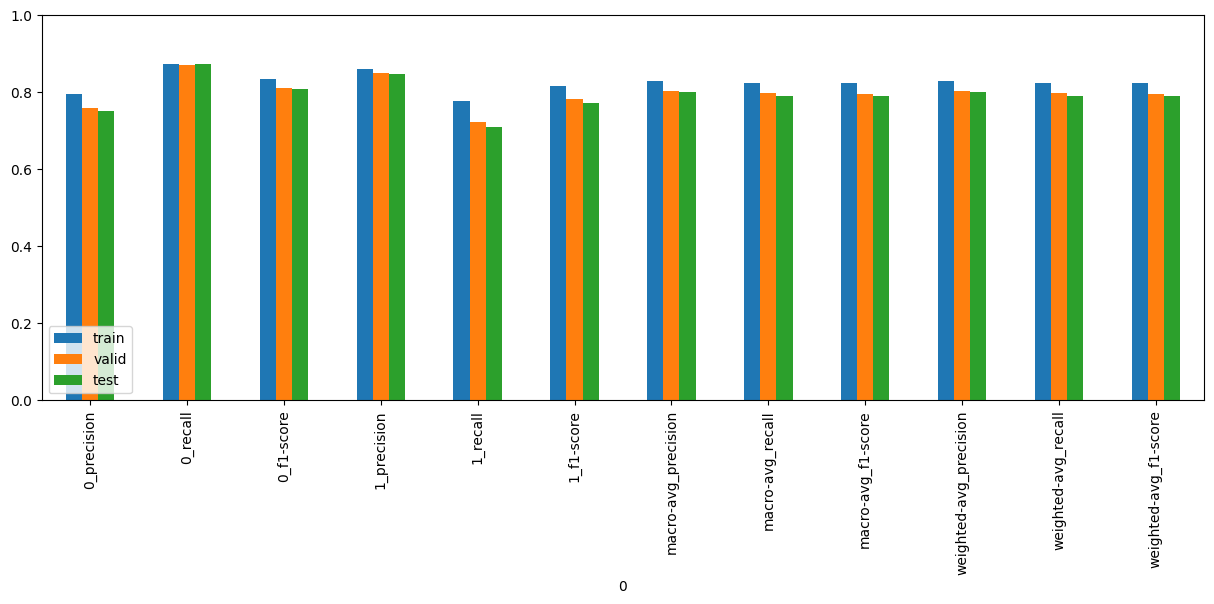

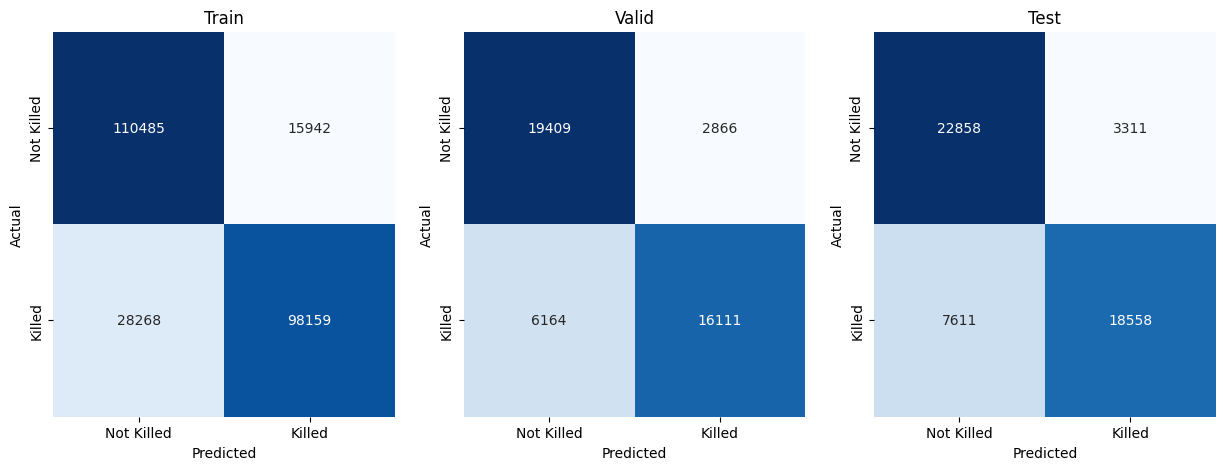

In [107]:
import seaborn as sns

def writable(class_report, base_key = '', separator = '_'):
    for key, value in class_report.items():
        if isinstance(value, dict):
            yield from writable(value, key)
        else:
            yield str(base_key + separator + key).replace(' ', '-'), value

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE)

y_pred_train = np.where(model(X_train_tensor).detach().cpu() > .5, 1, 0)[:, 1]
y_pred_valid = np.where(model(X_valid_tensor).detach().cpu() > .5, 1, 0)[:, 1]
y_pred_test  = np.where(model(X_test_tensor).detach().cpu()  > .5, 1, 0)[:, 1]

# Confusion matrices
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs[0][0].set_title('Train')
axs[0][1].set_title('Valid')
axs[0][2].set_title('Test')
sns.heatmap(confusion_matrix(y_train, y_pred_train, normalize='true'), annot=True, ax=axs[0][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid, normalize='true'), annot=True, ax=axs[0][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize='true'), annot=True, ax=axs[0][2], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_train, y_pred_train, normalize='pred'), annot=True, ax=axs[1][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid, normalize='pred'), annot=True, ax=axs[1][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize='pred'), annot=True, ax=axs[1][2], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', ax=axs[2][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt='d', ax=axs[2][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', ax=axs[2][2], cmap = 'Blues')
plt.show()

from sklearn.metrics import classification_report
# Scores
fig, ax = plt.subplots(figsize=(15, 5))
tr_cr = pd.DataFrame(writable(classification_report(y_train, y_pred_train, labels=[0, 1], output_dict=True), 'train'), columns=['0', 'train'])
tr_cr.set_index('0', inplace=True)
va_cr = pd.DataFrame(writable(classification_report(y_valid, y_pred_valid, labels=[0, 1], output_dict=True), 'valid'), columns=['0', 'valid'])
va_cr.set_index('0', inplace=True)
te_cr = pd.DataFrame(writable(classification_report(y_test, y_pred_test, labels=[0, 1], output_dict=True), 'test'), columns=['0', 'test'])
te_cr.set_index('0', inplace=True)

trvate = tr_cr.merge(va_cr, left_index=True, right_index=True)
trvate = trvate.merge(te_cr, left_index=True, right_index=True)

# remove all rows where index contains 'support'
trvate = trvate[~trvate.index.str.contains('support')]

trvate.plot.bar(ax=ax)
plt.ylim(0, 1)
plt.legend(loc='lower left')
plt.show()

# Plot for the paper
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('Train')
axs[1].set_title('Valid')
axs[2].set_title('Test')
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d' , ax=axs[0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt='d', ax=axs[1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', ax=axs[2], cmap = 'Blues')
for i in range(0, 3):
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')
    axs[i].set_xticklabels(['Not Killed', 'Killed'])
    axs[i].set_yticklabels(['Not Killed', 'Killed'])
    axs[i].collections[0].colorbar.remove()
# axs[0].set_xlabel('Predicted')
# axs[1].set_xlabel('Predicted')
# axs[2].set_xlabel('Predicted')
# axs[0].set_ylabel('Actual')
# axs[1].set_ylabel('Actual')
# axs[2].set_ylabel('Actual')
# axs[0].set_xticklabels(['Not Killed', 'Killed'])
# # remove colorbar
# axs[0].collections[0].colorbar.remove()
# axs[1].collections[0].colorbar.remove()
# axs[2].collections[0].colorbar.remove()
plt.show()

In [108]:
# scores
print('Train F1: {:.4f}'.format(f1_score(y_train, y_pred_train)))
print('Valid F1: {:.4f}'.format(f1_score(y_valid, y_pred_valid)))
print('Test F1: {:.4f}'.format(f1_score(y_test, y_pred_test)))

Train F1: 0.8162
Valid F1: 0.7811
Test F1: 0.7726


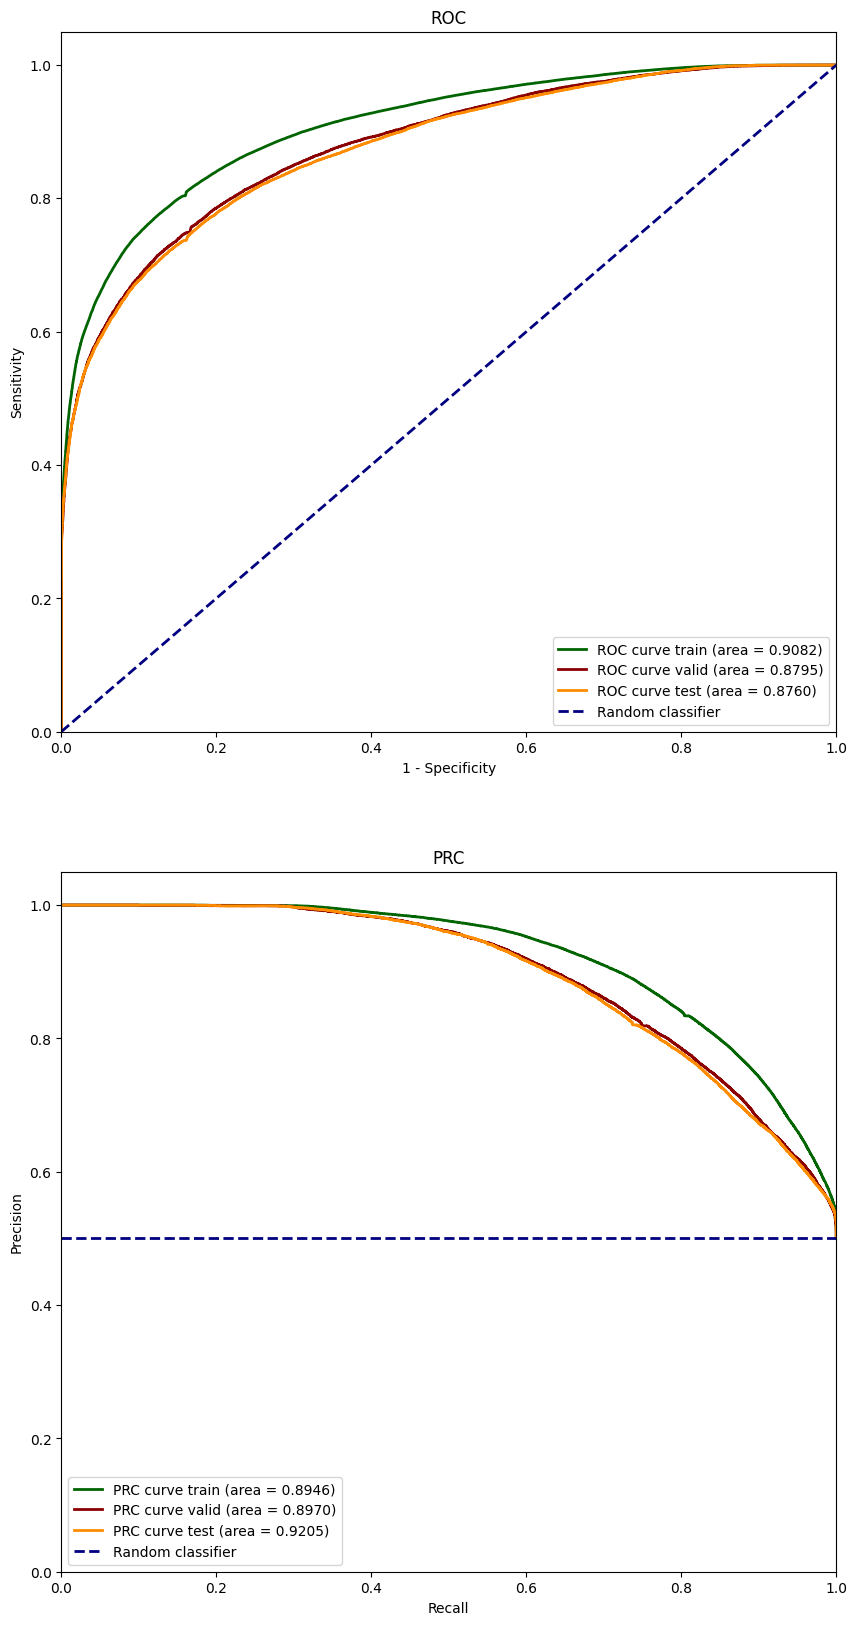

In [119]:
y_pred_train = model(X_train_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_train = np.where(y_pred_train > 0.5, 1, 0)
y_pred_valid = model(X_valid_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_valid = np.where(y_pred_valid > 0.5, 1, 0)
y_pred_test = model(X_test_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

# roc curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
y_pred_train = model(X_train_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_valid = model(X_valid_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_test = model(X_test_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()


fprr, tprr, thresholdsr = roc_curve(y_train, y_pred_train)
fprv, tprv, thresholdsv = roc_curve(y_valid, y_pred_valid)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

roc_aucr = auc(fprr, tprr)
roc_aucv = auc(fprv, tprv)
roc_auc = auc(fpr, tpr)


precr, recr, _ = precision_recall_curve(y_test, y_pred_test)
precv, recv, _ = precision_recall_curve(y_valid, y_pred_valid)
prect, rect, _ = precision_recall_curve(y_train, y_pred_train)

prc_aucr = auc(recr, precr)
prc_aucv = auc(recv, precv)
prc_auc = auc(rect, prect)


fig, axs = plt.subplots(2, 1, figsize=(10, 20))
ax = axs[0]
ax.plot(fprr, tprr, color='darkgreen', lw=2, label='ROC curve train (area = {:.4f})'.format(roc_aucr))
ax.plot(fprv, tprv, color='darkred', lw=2, label='ROC curve valid (area = {:.4f})'.format(roc_aucv))
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve test (area = {:.4f})'.format(roc_auc))
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
ax.set_title('ROC')
ax.legend(loc="lower right")

ax = axs[1]
ax.plot(rect, prect, color='darkgreen', lw=2, label='PRC curve train (area = {:.4f})'.format(prc_aucr))
ax.plot(recv, precv, color='darkred', lw=2, label='PRC curve valid (area = {:.4f})'.format(prc_aucv))
ax.plot(recr, precr, color='darkorange', lw=2, label='PRC curve test (area = {:.4f})'.format(prc_auc))
ax.plot([0, 1], [.5, .5], color='navy', lw=2, linestyle='--', label='Random classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('PRC')
ax.legend(loc="lower left")

plt.show()


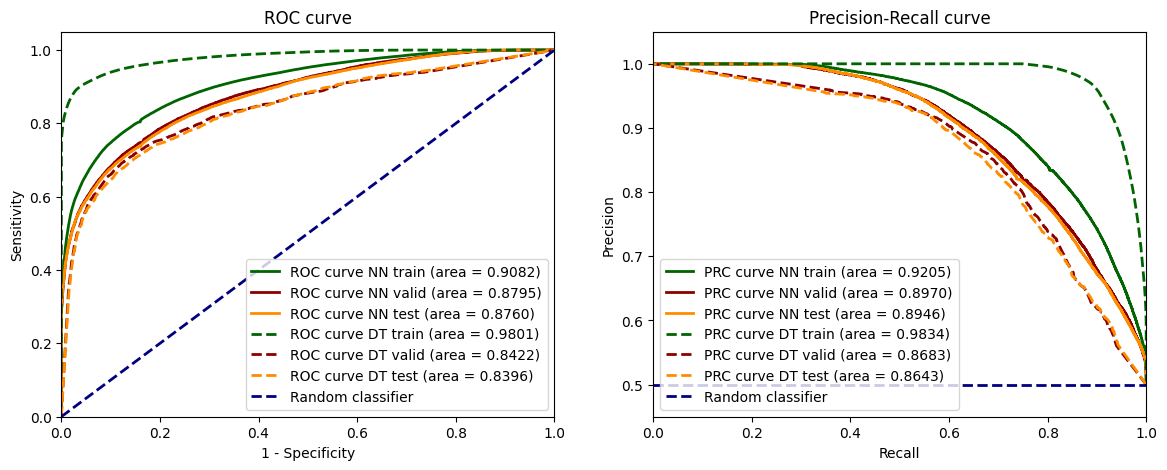

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
ax = axs[0]
ax.plot(fprr, tprr, color='darkgreen', lw=2, label='ROC curve NN train (area = {:.4f})'.format(roc_aucr))
ax.plot(fprv, tprv, color='darkred', lw=2, label='ROC curve NN valid (area = {:.4f})'.format(roc_aucv))
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve NN test (area = {:.4f})'.format(roc_auc))
ax.plot(fprr_dt, tprr_dt, color='darkgreen', lw=2, linestyle='--', label='ROC curve DT train (area = {:.4f})'.format(roc_aucr_dt))
ax.plot(fprv_dt, tprv_dt, color='darkred', lw=2, linestyle='--', label='ROC curve DT valid (area = {:.4f})'.format(roc_aucv_dt))
ax.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, linestyle='--', label='ROC curve DT test (area = {:.4f})'.format(roc_auc_dt))
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
# expand roc in the title
ax.set_title('ROC curve')
ax.legend(loc="lower right")

ax = axs[1]
ax.plot(rect, prect, color='darkgreen', lw=2, label='PRC curve NN train (area = {:.4f})'.format(prc_auc))
ax.plot(recv, precv, color='darkred', lw=2, label='PRC curve NN valid (area = {:.4f})'.format(prc_aucv))
ax.plot(recr, precr, color='darkorange', lw=2, label='PRC curve NN test (area = {:.4f})'.format(prc_aucr))
ax.plot(rect_dt, prect_dt, color='darkgreen', lw=2, linestyle='--', label='PRC curve DT train (area = {:.4f})'.format(prc_auc_dt))
ax.plot(recv_dt, precv_dt, color='darkred', lw=2, linestyle='--', label='PRC curve DT valid (area = {:.4f})'.format(prc_aucv_dt))
ax.plot(recr_dt, precr_dt, color='darkorange', lw=2, linestyle='--', label='PRC curve DT test (area = {:.4f})'.format(prc_aucr_dt))
ax.plot([0, 1], [.5, .5], color='navy', lw=2, linestyle='--', label='Random classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.45, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve')
ax.legend(loc="lower left")

plt.show()
